In [18]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
def f(x):
    return 3*x**2-4*x+5
    

In [20]:
f(3.0)

20.0

In [21]:
x_value=np.arange(-5,5,0.25)
x_value

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

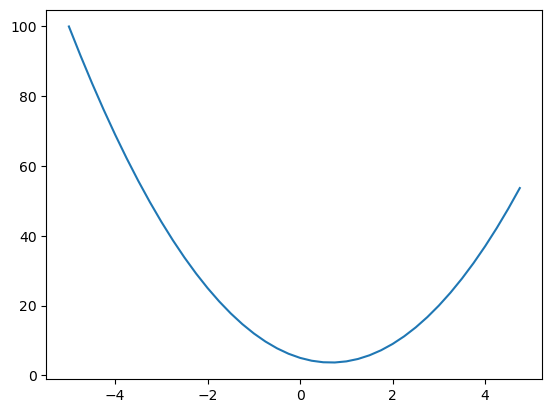

In [22]:
plt.plot(x_value,f(x_value))

In [104]:
class Value:
    def __init__(self,data,_children=(),_op='',label=''):
        self.data=data
        self.grad=0.0
        self._backward=lambda:None
        self._prev=set(_children)
        self._op=_op
        self.label=label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        output=Value(self.data+other.data,(self,other),'+')
        def _backward():
            self.grad+=1.0*output.grad
            other.grad+=1.0*output.grad
        output._backward=_backward
        return output
    
    def __mul__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        output=Value(self.data*other.data,(self,other),'*')
        def _backward():
            self.grad+=other.data*output.grad
            other.grad+=self.data*output.grad
        output._backward=_backward
        return output
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')
        
    def __rmul__(self, other): # other * self
        return self * other
     
    def __radd__(self, other): # other + self
        return self + other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)

   
    
    
    def tanh(self):##activation function
        x=self.data
        e=math.exp(2*x)
        t=(e-1)/(e+1)
        output=Value(t,(self,),'tanh')
        def _backward():
            self.grad=(1-t**2)*output.grad
        output._backward=_backward
        return output
    
    def backward(self):
        topo=[]
        visited=set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad=1.0
        for node in reversed(topo):
            node._backward()
        
    
    

In [105]:
from graphviz import Digraph

def traverse(root):
    nodes,edges=set(),set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes,edges
  
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes,edges = traverse(root)
    
    for _node in nodes:
        uid=str(id(_node))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (_node.label, _node.data, _node.grad), shape='record')
        if _node._op:
            dot.node(name = uid + _node._op, label = _node._op)
            dot.edge(uid + _node._op, uid)
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot
        
        

In [106]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L.backward()


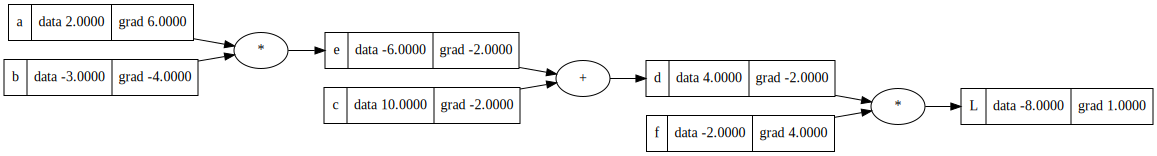

In [107]:
draw_dot(L)

In [108]:
#inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [109]:
o.backward()

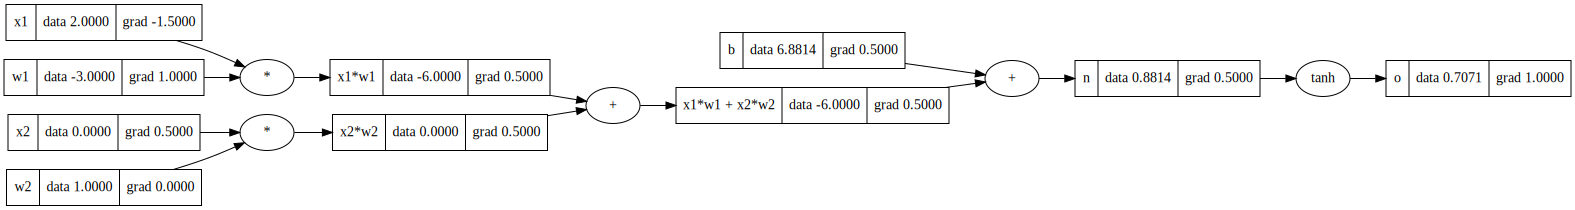

In [110]:
draw_dot(o)

In [111]:
import torch

In [112]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)


In [113]:
print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [114]:
##Simple Neuron

class SimpleNeuron:
    
    def __init__(self,input_n):
        self.w=[Value(np.random.uniform(-1,1)) for _ in range(input_n)]
        self.b=Value(np.random.uniform(-1,1))
    
    def __call__(self,x):
        activation=sum([ wi*xi for wi,xi in zip(self.w,x)],self.b)
        return activation.tanh()
    
    def parameters(self):
        return self.w +[self.b]
        
        

In [115]:
##Layer

class Layer:
    
    def __init__(self,input_n,output_n):
        self.neurons=[SimpleNeuron(input_n) for _ in range(output_n)]
    
    def __call__(self,x):
        outputs=[neuron(x) for neuron in self.neurons]
        return outputs[0] if len(outputs)==1 else outputs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
        
        

In [116]:
##Multi Layer Perceptron

class MLP:
    
    def __init__(self,input_n,outputs_n):
        inpouts=[input_n]+outputs_n
        self.layers=[Layer(inpouts[i],inpouts[i+1]) for i in range(len(outputs_n))]
    
    def __call__(self,x):
        for layer in self.layers:
            x=layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
        
        

In [117]:
s=SimpleNeuron(3)
s.w + [s.b]

[Value(data=-0.25411938280363766),
 Value(data=-0.06839077299539942),
 Value(data=-0.030551949625490238),
 Value(data=0.026525471402029765)]

In [118]:
l=Layer(3,2)
l.parameters()

[Value(data=-0.5004154535934882),
 Value(data=-0.5998242190887026),
 Value(data=0.5658084220934649),
 Value(data=-0.23731891160813867),
 Value(data=-0.530372472898097),
 Value(data=-0.07499322664452235),
 Value(data=-0.7993139418585888),
 Value(data=-0.3347856312250803)]

In [119]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=0.9190533445432703)

In [120]:
# example data

xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]


In [130]:
epoch=20
lr=0.1

for i in range(epoch):
    #forward pass
    y_pred=[n(x) for x in xs]
    loss = sum((yout.data - ygt)**2 for ygt, yout in zip(ys, y_pred))
    loss=Value(loss)
    
    #backward pass
    ###zero_grad
    for p in n.parameters():
        p.grad=0
    loss.backward()
    
    #update
    for p in n.parameters():
        p.data +=  -lr*p.grad
    
    print(i, loss.data)
        
    
    

0 7.1907653163039
1 7.1907653163039
2 7.1907653163039
3 7.1907653163039
4 7.1907653163039
5 7.1907653163039
6 7.1907653163039
7 7.1907653163039
8 7.1907653163039
9 7.1907653163039
10 7.1907653163039
11 7.1907653163039
12 7.1907653163039
13 7.1907653163039
14 7.1907653163039
15 7.1907653163039
16 7.1907653163039
17 7.1907653163039
18 7.1907653163039
19 7.1907653163039
